In [30]:
import sys
sys.path.append('../src/RAFT/core')

In [52]:
import cv2
import numpy as np
from typing import Tuple
import torch
from kornia.geometry.conversions import rotation_matrix_to_angle_axis, angle_axis_to_rotation_matrix,convert_points_to_homogeneous
from kornia.geometry.linalg import transform_points
from kornia.geometry.transform import remap
from kornia.utils import create_meshgrid
from typing import Optional
from kornia.geometry.calibration.distort import distort_points, tilt_projection
import os
import random
import json
from torch import nn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import argparse
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Import RAFT model
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

In [32]:
torch.autograd.set_detect_anomaly(True)

In [33]:
def undistort_points_like_cv2(points: torch.Tensor, K: torch.Tensor, dist: torch.Tensor, new_K: Optional[torch.Tensor] = None, num_iters: int = 5) -> torch.Tensor:
    r"""Compensate for lens distortion a set of 2D image points.

    Radial :math:`(k_1, k_2, k_3, k_4, k_5, k_6)`,
    tangential :math:`(p_1, p_2)`, thin prism :math:`(s_1, s_2, s_3, s_4)`, and tilt :math:`(\tau_x, \tau_y)`
    distortion models are considered in this function.

    Args:
        points: Input image points with shape :math:`(*, N, 2)`.
        K: Intrinsic camera matrix with shape :math:`(*, 3, 3)`.
        dist: Distortion coefficients
            :math:`(k_1,k_2,p_1,p_2[,k_3[,k_4,k_5,k_6[,s_1,s_2,s_3,s_4[,\tau_x,\tau_y]]]])`. This is
            a vector with 4, 5, 8, 12 or 14 elements with shape :math:`(*, n)`.
        new_K: Intrinsic camera matrix of the distorted image. By default, it is the same as K but you may additionally
            scale and shift the result by using a different matrix. Shape: :math:`(*, 3, 3)`. Default: None.
        num_iters: Number of undistortion iterations. Default: 5.
    Returns:
        Undistorted 2D points with shape :math:`(*, N, 2)`.
    """
    if points.dim() < 2 and points.shape[-1] != 2:
        raise ValueError(f'points shape is invalid. Got {points.shape}.')

    if K.shape[-2:] != (3, 3):
        raise ValueError(f'K matrix shape is invalid. Got {K.shape}.')

    if new_K is None:
        new_K = K
    elif new_K.shape[-2:] != (3, 3):
        raise ValueError(f'new_K matrix shape is invalid. Got {new_K.shape}.')

    if dist.shape[-1] not in [4, 5, 8, 12, 14]:
        raise ValueError(f"Invalid number of distortion coefficients. Got {dist.shape[-1]}")

    # Adding zeros to obtain vector with 14 coeffs.
    if dist.shape[-1] < 14:
        dist = torch.nn.functional.pad(dist, [0, 14 - dist.shape[-1]])

    # Convert 2D points from pixels to normalized camera coordinates
    cx: torch.Tensor = K[..., 0:1, 2]  # princial point in x (Bx1)
    cy: torch.Tensor = K[..., 1:2, 2]  # princial point in y (Bx1)
    fx: torch.Tensor = K[..., 0:1, 0]  # focal in x (Bx1)
    fy: torch.Tensor = K[..., 1:2, 1]  # focal in y (Bx1)

    # This is equivalent to K^-1 [u,v,1]^T
    x: torch.Tensor = (points[..., 0] - cx) / fx  # (BxN - Bx1)/Bx1 -> BxN
    y: torch.Tensor = (points[..., 1] - cy) / fy  # (BxN - Bx1)/Bx1 -> BxN

    # Compensate for tilt distortion
    if torch.any(dist[..., 12] != 0) or torch.any(dist[..., 13] != 0):
        inv_tilt = tilt_projection(dist[..., 12], dist[..., 13], True)

        # Transposed untilt points (instead of [x,y,1]^T, we obtain [x,y,1])
        x, y = transform_points(inv_tilt, torch.stack([x, y], dim=-1)).unbind(-1)

    # Iteratively undistort points
    x0, y0 = x, y
    for _ in range(num_iters):
        r2 = x * x + y * y

        inv_rad_poly = (1 + dist[..., 5:6] * r2 + dist[..., 6:7] * r2 * r2 + dist[..., 7:8] * r2 ** 3) / (
            1 + dist[..., 0:1] * r2 + dist[..., 1:2] * r2 * r2 + dist[..., 4:5] * r2 ** 3
        )
        deltaX = (
            2 * dist[..., 2:3] * x * y
            + dist[..., 3:4] * (r2 + 2 * x * x)
            + dist[..., 8:9] * r2
            + dist[..., 9:10] * r2 * r2
        )
        deltaY = (
            dist[..., 2:3] * (r2 + 2 * y * y)
            + 2 * dist[..., 3:4] * x * y
            + dist[..., 10:11] * r2
            + dist[..., 11:12] * r2 * r2
        )

        x = (x0 - deltaX) * inv_rad_poly
        y = (y0 - deltaY) * inv_rad_poly

        # print(x.shape)
        # print(y.shape)

    '''
      This is done to match OpenCV implementation of undistortPoints
    '''

    # Convert points from normalized camera coordinates to pixel coordinates
    # new_cx: torch.Tensor = new_K[..., 0:1, 2]  # princial point in x (Bx1)
    # new_cy: torch.Tensor = new_K[..., 1:2, 2]  # princial point in y (Bx1)
    # new_fx: torch.Tensor = new_K[..., 0:1, 0]  # focal in x (Bx1)
    # new_fy: torch.Tensor = new_K[..., 1:2, 1]  # focal in y (Bx1)
    # x = new_fx * x + new_cx
    # y = new_fy * y + new_cy
    return torch.stack([x, y], -1)

In [34]:
def stereorectify_torch(cameraMatrix1:torch.Tensor, distCoeff1: torch.Tensor, cameraMatrix2:torch.Tensor,
                        distCoeff2: torch.Tensor,img_size:Tuple[np.uint16,np.uint16],
                        R:torch.Tensor, T:torch.Tensor, new_image_size: Optional[Tuple[np.uint16,np.uint16]] = (0,0)):


  b,_, _ = cameraMatrix1.shape

  uu = torch.zeros(b,3,1, device=cameraMatrix1.device)

  nx, ny = img_size

  if len(R.shape) == 3 and R.shape[1] == 3 and R.shape[2] == 3: # R is in Rotation Matrix format
    om = rotation_matrix_to_angle_axis(R)                       # get vector rotation format
  else:
    om = R

  om *= -0.5 # get average rotation

  r_r = angle_axis_to_rotation_matrix(om) # rotate cameras to same orientation by averaging
  t = r_r @ T

  idx = torch.where(torch.abs(t[:,0,0]) > torch.abs(t[:,1,0]),0,1).type(torch.long)
  c = torch.gather(t.squeeze(2), dim=1, index = idx.reshape(-1,1))
  nt = torch.linalg.norm(t,ord=2,dim=1)
  uu = torch.scatter(uu.squeeze(2),dim=1, index = idx.reshape(-1,1), src=torch.where(c > 0, 1.0, -1.0)).unsqueeze(2).double()

  assert torch.all(nt>0), 'L2 norm should be positive'

  # Calculate global Z rotation
  ww_ = torch.cross(t.squeeze(2),uu.squeeze(2)).unsqueeze(2)
  nw = torch.linalg.norm(ww_,ord=2,dim=1)
  pos_nw_indx = torch.where(nw > 0.0)[0]
  
  ww = ww_.clone() # cloning to avoid in-place operation

  ww[pos_nw_indx]  *= (torch.acos(torch.abs(c[pos_nw_indx])/nt[pos_nw_indx])/nw[pos_nw_indx]).unsqueeze(1)
  wR = angle_axis_to_rotation_matrix(ww.squeeze(2))

  # apply to both views 
  R1 = wR @ r_r.transpose(1,2)
  R2 = wR @ r_r
  t = R2 @ T

  # calculate projection/camera matrices
  # these contain the relevant rectified image internal params (fx, fy=fx, cx, cy)
  new_image_size = new_image_size if new_image_size[0] * new_image_size[1] else (nx,ny)
  ratio_x = (new_image_size[0] / nx) * 0.5
  ratio_y = (new_image_size[1] / ny) * 0.5
  ratio = ratio_y * torch.ones_like(idx)
  ratio[torch.where(idx==1)[0]] = ratio_x

  fc_new = (torch.gather(torch.diagonal(cameraMatrix1,dim1=-2,dim2=-1), 1, torch.bitwise_xor(idx,torch.ones_like(idx)).view(-1,1)).squeeze(1) +
          torch.gather(torch.diagonal(cameraMatrix2,dim1=-2,dim2=-1), 1, torch.bitwise_xor(idx,torch.ones_like(idx)).view(-1,1)).squeeze(1)) * ratio

  cc_new_x = torch.zeros(b,2)
  cc_new_y = torch.zeros(b,2)

  for k in range(2): # k = 0 is left camera and k = 1 is left camera
    A = cameraMatrix1 if k == 0 else cameraMatrix2
    Dk = distCoeff1 if k == 0 else distCoeff2 

    pts = torch.Tensor([[0,      0    ],
                        [nx - 1, 0    ],
                        [0,      ny -1],
                        [nx - 1, ny -1]]).repeat(b,1,1)
    pts = undistort_points_like_cv2(pts,A,Dk)
    pts_3 = convert_points_to_homogeneous(pts)
    
    # Change camera matrix to have cc=[0,0] and fc = fc_new
    A_tmp = torch.eye(3).double().repeat(b,1,1)
    A_tmp[:,0,0] = fc_new
    A_tmp[:,1,1] = fc_new

    # project points to image with A-tmp as intrinsics
    R_tmp = R1 if k == 0 else R2
    pts_tmp = A_tmp @ R_tmp @ pts_3.transpose(1,2)
    pts = pts_tmp/pts_tmp[:,2,:].reshape(-1,1,4)
    avg = torch.mean(pts,dim=2)[:,:2]

    cc_new_x[:,k] = (nx-1)/2.0 - avg[:,0]
    cc_new_y[:,k] = (ny-1)/2.0 - avg[:,1]

  # For simplicity, set the principal points for both cameras to be the average
  # of the two principal points (either one of or both x- and y- coordinates)
  # This is CALIB_ZERO_DISPARITY flag for opencv
  cc_mean_x = torch.mean(cc_new_x,dim=1)
  cc_new_x[:,0] = cc_mean_x
  cc_new_x[:,1] = cc_mean_x

  cc_mean_y = torch.mean(cc_new_y,dim=1)
  cc_new_y[:,0] = cc_mean_y
  cc_new_y[:,1] = cc_mean_y

  # constructing projection matrix
  P1 = torch.zeros(b,3,4).double()
  P2 = torch.zeros(b,3,4).double()

  P1[:,0,0] = fc_new
  P1[:,1,1] = fc_new
  P1[:,0,2] = cc_new_x[:,0]
  P1[:,1,2] = cc_new_y[:,0]
  P1[:,2,2] = 1.0

  P2[:,0,0] = fc_new
  P2[:,1,1] = fc_new
  P2[:,0,2] = cc_new_x[:,1]
  P2[:,1,2] = cc_new_y[:,1]
  bf = torch.gather(t.squeeze(2), dim=1, index = idx.reshape(-1,1)).squeeze(1) * fc_new

  # setting P2[idx][3] = bf 
  idx_zero = torch.where(idx==0)[0]
  idx_one = torch.where(idx==1)[0]
  P2[idx_zero,0,3] = bf[idx_zero]
  P2[idx_one,1,3] = bf[idx_one]

  # Constructing Q matrix
  matQ = torch.eye(4).repeat(b,1,1).double()
  matQ[:,0,3] = -cc_new_x[:,0]
  matQ[:,1,3] = -cc_new_y[:,0]
  matQ[:,2,3] = fc_new
  matQ[:,3,2] = -1.0/torch.gather(t.squeeze(2), dim=1, index = idx.reshape(-1,1)).squeeze(1)

  return R1, R2, P1, P2, matQ

In [35]:
def undistortrectify(image: torch.Tensor, K: torch.Tensor, dist: torch.Tensor, R: torch.Tensor, new_K: Optional[torch.Tensor] = None
                   ) -> torch.Tensor:
    
    if len(image.shape) < 3:
        raise ValueError(f"Image shape is invalid. Got: {image.shape}.")

    if K.shape[-2:] != (3, 3):
        raise ValueError(f'K matrix shape is invalid. Got {K.shape}.')
    
    if R.shape[-2:] != (3, 3):
        print(R)
        raise ValueError(f'R matrix shape is invalid. Got {R.shape}.')

    if new_K is None:
        new_K = K
    elif new_K.shape[-2:] != (3, 3):
        raise ValueError(f'new_K matrix shape is invalid. Got {new_K.shape}.')

    if dist.shape[-1] not in [4, 5, 8, 12, 14]:
        raise ValueError(f'Invalid number of distortion coefficients. Got {dist.shape[-1]}')

    # Adding zeros to obtain vector with 14 coeffs.
    if dist.shape[-1] < 14:
        dist = torch.nn.functional.pad(dist, [0, 14 - dist.shape[-1]])


    if not image.is_floating_point():
        raise ValueError(f'Invalid input image data type. Input should be float. Got {image.dtype}.')

    if image.shape[:-3] != K.shape[:-2] or image.shape[:-3] != dist.shape[:-1]:
        # Input with image shape (1, C, H, W), K shape (3, 3), dist shape (4)
        # allowed to avoid a breaking change.
        if not all((image.shape[:-3] == (1,), K.shape[:-2] == (), dist.shape[:-1] == ())):
            raise ValueError(
                f'Input shape is invalid. Input batch dimensions should match. '
                f'Got {image.shape[:-3]}, {K.shape[:-2]}, {dist.shape[:-1]}.'
            )

    channels, rows, cols = image.shape[-3:]
    B = image.numel() // (channels * rows * cols)

    # Create point coordinates for each pixel of the image
    xy_grid: torch.Tensor = create_meshgrid(rows, cols, False, image.device, image.dtype)
    points = xy_grid.reshape(-1, 2)  # (rows*cols)x2 matrix of pixel coordinates

    # Convert 2D points from pixels to normalized camera coordinates
    new_cx: torch.Tensor = new_K[..., 0:1, 2]  # princial point in x (Bx1)
    new_cy: torch.Tensor = new_K[..., 1:2, 2]  # princial point in y (Bx1)
    new_fx: torch.Tensor = new_K[..., 0:1, 0]  # focal in x (Bx1)
    new_fy: torch.Tensor = new_K[..., 1:2, 1]  # focal in y (Bx1)

    # This is equivalent to K^-1 [u,v,1]^T
    x: torch.Tensor = (points[..., 0] - new_cx) / new_fx  # (BxN - Bx1)/Bx1 -> BxN or (N,)
    y: torch.Tensor = (points[..., 1] - new_cy) / new_fy  # (BxN - Bx1)/Bx1 -> BxN or (N,)

    # Applying R^-1 * [x,y,1]^T to get [X,Y,W]. Then x = X/W, y = Y/W
    R_inv = torch.inverse(R)
    p = torch.stack([x,y,torch.ones_like(x)],dim=1).type_as(R)
    XYW = R_inv @ p
    xy = XYW/XYW[:,2,:].reshape(-1,1,XYW.shape[-1])
    x: torch.Tensor = xy[:,0,:].float() 
    y: torch.Tensor = xy[:,1,:].float()

    # Distort points
    r2 = x * x + y * y

    rad_poly = (1 + dist[..., 0:1] * r2 + dist[..., 1:2] * r2 * r2 + dist[..., 4:5] * r2 ** 3) / (
        1 + dist[..., 5:6] * r2 + dist[..., 6:7] * r2 * r2 + dist[..., 7:8] * r2 ** 3
    )
    xd = (
        x * rad_poly
        + 2 * dist[..., 2:3] * x * y
        + dist[..., 3:4] * (r2 + 2 * x * x)
        + dist[..., 8:9] * r2
        + dist[..., 9:10] * r2 * r2
    )
    yd = (
        y * rad_poly
        + dist[..., 2:3] * (r2 + 2 * y * y)
        + 2 * dist[..., 3:4] * x * y
        + dist[..., 10:11] * r2
        + dist[..., 11:12] * r2 * r2
    )

    # Compensate for tilt distortion
    if torch.any(dist[..., 12] != 0) or torch.any(dist[..., 13] != 0):
        tilt = tilt_projection(dist[..., 12], dist[..., 13])

        # Transposed untilt points (instead of [x,y,1]^T, we obtain [x,y,1])
        points_untilt = torch.stack([xd, yd, torch.ones_like(xd)], -1) @ tilt.transpose(-2, -1)
        xd = points_untilt[..., 0] / points_untilt[..., 2]
        yd = points_untilt[..., 1] / points_untilt[..., 2]

    # Convert points from normalized camera coordinates to pixel coordinates
    cx: torch.Tensor = K[..., 0:1, 2]  # princial point in x (Bx1)
    cy: torch.Tensor = K[..., 1:2, 2]  # princial point in y (Bx1)
    fx: torch.Tensor = K[..., 0:1, 0]  # focal in x (Bx1)
    fy: torch.Tensor = K[..., 1:2, 1]  # focal in y (Bx1)

    x = fx * xd + cx
    y = fy * yd + cy

    ptsd = torch.stack([x, y], -1)

    mapx: torch.Tensor = ptsd[..., 0].reshape(B, rows, cols)  # B x rows x cols, float
    mapy: torch.Tensor = ptsd[..., 1].reshape(B, rows, cols)  # B x rows x cols, float

    # Remap image to undistort
    out = remap(image.reshape(B, channels, rows, cols), mapx.type_as(image), mapy.type_as(image), align_corners=True)

    return out.view_as(image) 

### Applying rectification

In [36]:
is_left_pertb = True
is_right_pertb = True
cam_left,cam_right = 0,1

In [37]:
carla_data_dir = f'/nas/EOS/users/siva/data/carla_data/simulations/rand_weather_camera_pert_2/night_Town06'
fnames = os.listdir(carla_data_dir+'/cam_poses')
img_fids = list(map(lambda x : x.split('.')[0],fnames))

In [38]:
# fid = random.choice(img_fids) # 02638214
fid = '00005183'
cam_num = 0 # 0-3
print('camera number = {}, image id = {}'.format(cam_num,fid))

camera number = 0, image id = 00005183


In [39]:
if is_left_pertb:
    image_left_pb = cv2.imread(os.path.join(carla_data_dir,f'cam_p_{cam_left}',fid+'.png'))
else:
    image_left_pb = cv2.imread(os.path.join(carla_data_dir,f'cam_{cam_left}',fid+'.png'))

if is_left_pertb:
    image_right_pb = cv2.imread(os.path.join(carla_data_dir,f'cam_p_{cam_right}',fid+'.png'))
else:
    image_right_pb = cv2.imread(os.path.join(carla_data_dir,f'cam_{cam_right}',fid+'.png'))

In [40]:
with open(os.path.join(carla_data_dir,'cam_poses',f'{fid}.json')) as fh:
    calib_data = json.load(fh)

In [41]:
if is_left_pertb:
    T_carla_cam0 = np.array(calib_data[f'rgb_p_cam{cam_left}_matrix'])
else:
    T_carla_cam0 = np.array(calib_data[f'rgb_cam{cam_left}_matrix'])

if is_right_pertb:
    T_carla_cam1 = np.array(calib_data[f'rgb_p_cam{cam_right}_matrix'])
else:
    T_carla_cam1 = np.array(calib_data[f'rgb_cam{cam_right}_matrix'])


In [42]:
P = np.array([[0,1,0,0],[0,0,-1,0],[1,0,0,0],[0,0,0,1]])

In [43]:
T_opencv_cam0 = P @ T_carla_cam0 @ np.linalg.inv(P)
T_opencv_cam1 = P @ T_carla_cam1 @ np.linalg.inv(P)

T_opencv_cam0_inv = np.linalg.inv(T_opencv_cam0)
T_opencv_cam1_inv = np.linalg.inv(T_opencv_cam1)

R_opencv_cam0, t_opencv_cam0 = T_opencv_cam0_inv[0:3,0:3], T_opencv_cam0_inv[0:3,3]
R_opencv_cam1, t_opencv_cam1 = T_opencv_cam1_inv[0:3,0:3], T_opencv_cam1_inv[0:3,3]
R = R_opencv_cam1 @ R_opencv_cam0.T
t =  (t_opencv_cam1 - R @ t_opencv_cam0)

In [44]:
fov = 44.343
height,width,_ = image_left_pb.shape
focal_length = width / (2.0 * np.tan(fov * np.pi / 360.0))

K = np.array([[focal_length, 0, width/2],
              [0, focal_length, height/2],
              [0, 0, 1]])

In [45]:
totensor = ToTensor()

In [46]:
image_left_pb_tensor = totensor(image_left_pb).unsqueeze(0)
image_right_pb_tensor = totensor(image_right_pb).unsqueeze(0)

K = torch.from_numpy(K).unsqueeze(0)
R = torch.from_numpy(R).unsqueeze(0)
t = torch.from_numpy(t).unsqueeze(0).unsqueeze(-1)
dist1 = torch.from_numpy(np.zeros((8,))).unsqueeze(0)
dist2 = torch.from_numpy(np.zeros((8,))).unsqueeze(0)

R.requires_grad = True

In [47]:
# R1,R2,P1,P2,Q = stereorectify_torch(K,dist1,K,dist2, (width,height),R,t)

In [48]:
def calibrate_stereo_pair(img_left, img_right, K_left, K_right, dist_left, dist_right, R, t, height, width):
    # Getting left and right rectify maps
    
    R1,R2,P1,P2,Q = stereorectify_torch(K_left,dist_left,K,dist_right, (width,height),R,t)
    print("R1 = ", R1.detach().numpy())
    print("R2 = ", R2.detach().numpy())
    print("P1 = ", P1.detach().numpy())
    print("P2 = ", P2.detach().numpy())
    
    img_left_rect =  undistortrectify(img_left,K_left,dist_left,R1,P1[...,:3])
    img_right_rect = undistortrectify(img_right,K_right,dist_right,R2,P2[...,:3])

    return img_left_rect, img_right_rect

In [49]:
img_left_rect, img_right_rect = calibrate_stereo_pair(image_left_pb_tensor, image_right_pb_tensor, K, K, dist1, dist2, R, t, height, width)

R1 =  [[[ 0.99983011  0.01668269  0.0078358 ]
  [-0.01675889  0.99981188  0.0097624 ]
  [-0.00767147 -0.00989206  0.99992162]]]
R2 =  [[[ 0.99997753  0.00485645  0.00461628]
  [-0.00481085  0.99994    -0.00983881]
  [-0.00466378  0.00981638  0.99994092]]]
P1 =  [[[3.14100949e+03 0.00000000e+00 1.25722327e+03 0.00000000e+00]
  [0.00000000e+00 3.14100949e+03 7.20147461e+02 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]]
P2 =  [[[ 3141.00948745     0.          1257.2232666  -2512.80490516]
  [    0.          3141.00948745   720.14746094     0.        ]
  [    0.             0.             0.             0.        ]]]


In [50]:
z = torch.abs(img_left_rect - torch.ones_like(img_left_rect)).mean() 
z2 = torch.abs(img_right_rect - torch.ones_like(img_left_rect)).mean()

In [21]:
y = z + z2

In [22]:

y.backward()

In [23]:
img_left_rect.shape

torch.Size([1, 3, 1440, 2560])

In [24]:
img_rectf_left_d = (img_left_rect.permute(0,2,3,1)[0].detach().numpy() * 255.0).astype(np.uint8)
img_rectf_right_d = (img_right_rect.permute(0,2,3,1)[0].detach().numpy() * 255.0).astype(np.uint8)

In [25]:
def draw_epipolar_lines(image1,image2, num_lines = 100,line_color=(0,255,0), line_thickness=2, text = None):
    assert image1.shape == image2.shape, "two image dimensions are of different dimensions"
    h,w,_ = image1.shape
    comb = np.concatenate((image1,image2),axis=1) # concatenating along width dimesnion
    comb = np.ascontiguousarray(comb,np.uint8)
    delta = h//num_lines
    left_indxs = np.arange(0, h, delta)
    for indx in left_indxs:
        cv2.line(comb, (0,indx),(2*w,indx),line_color,line_thickness)
    
    if text is not None:
        cv2.putText(comb,text,(100,100),cv2.FONT_HERSHEY_SIMPLEX,3,(255,255,255),3)
    return comb

In [26]:
ep_pair1 = draw_epipolar_lines(img_rectf_left_d,img_rectf_right_d,50,(0,0,0),text=fid)

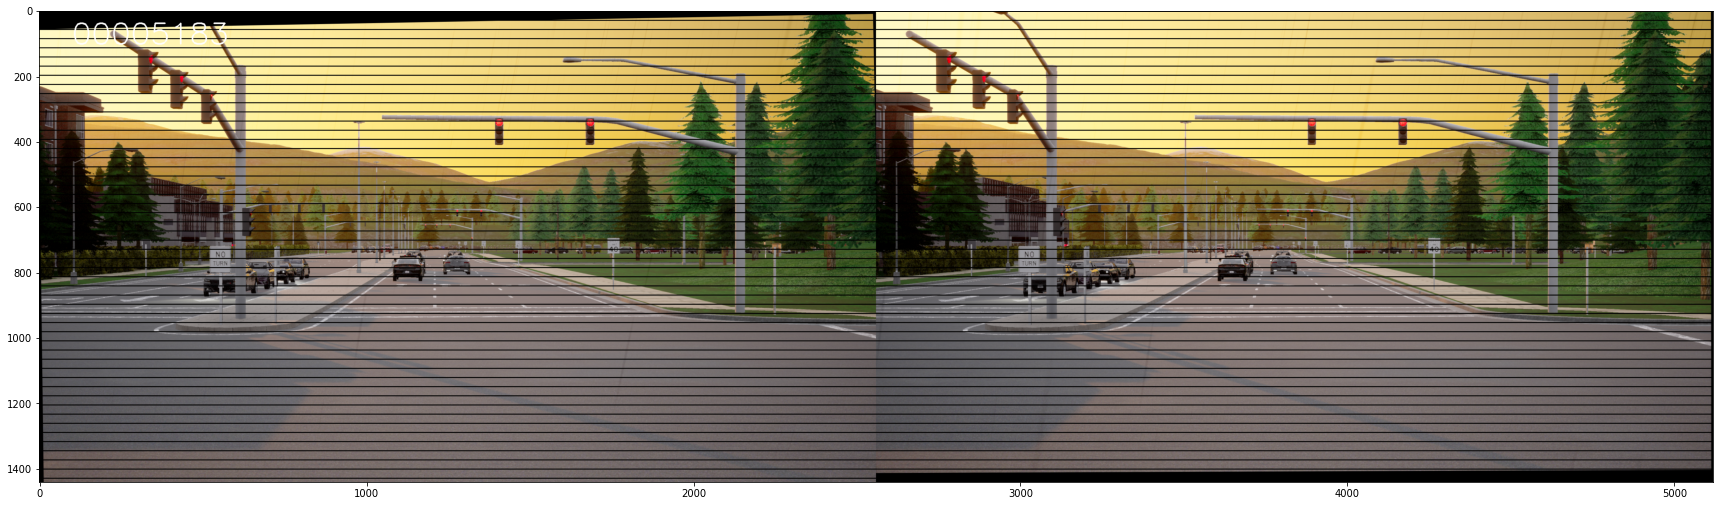

In [27]:
figure,axes = plt.subplots(1,1,figsize=(30,20))
axes.imshow(ep_pair1[...,::-1])
figure.show()